# Import Packages

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import utils
from sklearn.metrics import mean_squared_error
import numpy as np
from isoweek import Week
import math
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import pickle
import matplotlib.pyplot as plt


# Settings

In [2]:
path_models = utils.get_project_root() + '/Forecasting - Benchmark/models/'

forecast_horizon = 1

target_variable = 'Turnover' # Either 'Turnover' or 'Sales_QTY'

# Import Sales Data

In [3]:
query = 'SELECT * FROM `globus-datahub-dev.Verteiler_PoC.timeseries_sales_weekly` where Year <= 2019 OR (Year = 2020 AND Week <= 47) order by sku, site_id, year, week'
df_raw = utils.bq_to_dataframe(
    query, verbose=True).pipe(utils.reduce_memory_usage)

********************
Query Duration:  0:02:08.849024
Mem. usage decreased to 581.29 Mb (13.8% reduction)


In [4]:
df = df_raw.copy()
df

,Week,Year,Date,Site_ID,SKU,Sales_QTY,Turnover,Season_Year,Vendor_ID,Vendor_Name,...,Warengruppe_ID,Warengruppe_Desc,Subclass_Desc,Class_Desc,Web_Article,Web_Article_From,Web_Article_To,CENSHARE_CAT_1,CENSHARE_CAT_2,CENSHARE_CAT_3
0,26,2010,2010W26,101,2069466,1.0,31.900000,9999,0000194449,Hanro AG,...,567,Wäsche/Bade,Initial,Slip,X,2014-02-10,2020-11-17,Herren,Wasche/Pyjamas,slip
1,27,2010,2010W27,101,2069466,0.0,0.000000,9999,0000194449,Hanro AG,...,567,Wäsche/Bade,Initial,Slip,X,2014-02-10,2020-11-17,Herren,Wasche/Pyjamas,slip
2,28,2010,2010W28,101,2069466,1.0,31.900000,9999,0000194449,Hanro AG,...,567,Wäsche/Bade,Initial,Slip,X,2014-02-10,2020-11-17,Herren,Wasche/Pyjamas,slip
3,29,2010,2010W29,101,2069466,6.0,191.399994,9999,0000194449,Hanro AG,...,567,Wäsche/Bade,Initial,Slip,X,2014-02-10,2020-11-17,Herren,Wasche/Pyjamas,slip
4,30,2010,2010W30,101,2069466,0.0,0.000000,9999,0000194449,Hanro AG,...,567,Wäsche/Bade,Initial,Slip,X,2014-02-10,2020-11-17,Herren,Wasche/Pyjamas,slip
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3158140,47,2020,2020W47,102,1288695802,1.0,69.900002,9999,0000946191,Calvin Klein Europe BV,...,567,Wäsche/Bade,Initial,Boxershorts,X,2020-10-08,9999-12-31,Herren,Wasche/Pyjamas,shortsimdoppelpack
3158141,47,2020,2020W47,115,1288695802,2.0,139.800003,9999,0000946191,Calvin Klein Europe BV,...,567,Wäsche/Bade,Initial,Boxershorts,X,2020-10-08,9999-12-31,Herren,Wasche/Pyjamas,shortsimdoppelpack
3158142,47,2020,2020W47,103,1288743328,1.0,179.000000,2021,0000941918,RALPH LAUREN GERMANY GMBH,...,564,Casual-Marken O,Initial,Strick LA,X,2020-11-30,9999-12-31,Herren,Pullover&Strick,strickpullover
3158143,47,2020,2020W47,101,1289250705,1.0,99.000000,9999,0000948574,Santoni S.P.A.,...,570,Herrenschuhe,Schuhzubehör,Furnituren,X,2020-10-29,9999-12-31,Damen Accessoires,Schuhpflege,schuhzubehoer


# Data Preprocessing

In [5]:
# keep only relevant columns
df = df[['Week', 'Year', 'Site_ID', 'SKU', 'Sales_QTY', 'Turnover','Season_Year',
       'Vendor_ID','Price_Level','Web_Article','CENSHARE_CAT_1', 'CENSHARE_CAT_2', 'CENSHARE_CAT_3']].copy()

In [6]:
# Get rid of negative Sales
df.loc[:, 'Sales_QTY'] = df.Sales_QTY.clip(lower=0)
df.loc[:, 'Turnover'] = df.Sales_QTY.clip(lower=0)

In [7]:
# Convert categorical features to integers 
df = utils.encode_categorical(df, ['Site_ID', 'SKU','Season_Year','Vendor_ID','Web_Article','Price_Level', 'CENSHARE_CAT_1',
       'CENSHARE_CAT_2', 'CENSHARE_CAT_3'], downcast_cols=False)

# Feature Engineering

In [8]:
df['rolling_mean_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=4).mean())

df['rolling_mean_w8'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1).rolling(window=8).mean())

df['lag_w1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(1))

df['lag_w2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(2))

df['lag_w3'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(3))

df['lag_w4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(4))

df['lag_y1'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(52))

df['lag_y2'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])[target_variable].transform(lambda x: x.shift(104))


In [9]:
df

,Week,Year,Site_ID,SKU,Sales_QTY,Turnover,Season_Year,Vendor_ID,Price_Level,Web_Article,...,CENSHARE_CAT_2,CENSHARE_CAT_3,rolling_mean_w4,rolling_mean_w8,lag_w1,lag_w2,lag_w3,lag_w4,lag_y1,lag_y2
0,26,2010,0,0,1.0,1.0,6,14,4,1,...,25,84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27,2010,0,0,0.0,0.0,6,14,4,1,...,25,84,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,28,2010,0,0,1.0,1.0,6,14,4,1,...,25,84,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN
3,29,2010,0,0,6.0,6.0,6,14,4,1,...,25,84,NaN,NaN,1.0,0.0,1.0,NaN,NaN,NaN
4,30,2010,0,0,0.0,0.0,6,14,4,1,...,25,84,2.0,NaN,6.0,1.0,0.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3158140,47,2020,1,5338,1.0,1.0,6,49,3,1,...,25,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3158141,47,2020,5,5338,2.0,2.0,6,49,3,1,...,25,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3158142,47,2020,2,5339,1.0,1.0,5,24,4,1,...,14,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3158143,47,2020,0,5340,1.0,1.0,6,86,4,1,...,18,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#  Forecasting

In [10]:
cat_features = [
'Week', 'Year', 'Site_ID', 'SKU','Season_Year',
       'Vendor_ID', 'Price_Level', 'Web_Article', 'CENSHARE_CAT_1',
       'CENSHARE_CAT_2', 'CENSHARE_CAT_3'
]

num_features = [
'rolling_mean_w4', 'lag_w1',
       'lag_w2', 'lag_w3', 'lag_w4', 'lag_y1', 'lag_y2'
]

features = cat_features + num_features

In [11]:
splits = utils.get_splits(df, fh=forecast_horizon, n_splits=5)

In [12]:
model_params = {
    'seed': 10,
    'objective': 'poisson',
    'metric': 'rmse',
    'num_leaves': 2^4,
    'max_bin': 1000,
    }

In [13]:
rmse = []

for week, year in splits:
    print(f'\n\n****** {year}W{week} ******')
    
    evals_result = {}
    
    week=int(week)
    year=int(year)
    
    # Train data: same year and past week OR past year
    x_train = df.loc[((df.Year == (Week(year, week))[0]) & (df.Week <= (Week(year, week))[1])) | (df.Year < (Week(year, week))[0])][features]
    y_train = df.loc[((df.Year == (Week(year, week))[0]) & (df.Week <= (Week(year, week))[1])) | (df.Year < (Week(year, week))[0])][target_variable]

    x_test = df.loc[df.Year == (Week(year, week)+1)[0]].loc[df.Week == (Week(year, week)+1)[1]][features]
    y_test = df.loc[df.Year == (Week(year, week)+1)[0]].loc[df.Week == (Week(year, week)+1)[1]][target_variable]
    
    
    
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )
    
    
    
    gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                   )

    
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
    
    
    print('log: save model and evals result')
    gbm.save_model(path_models + f'gbm_{year}w{week}.txt', num_iteration=gbm.best_iteration) 
    
    evals_result_p = open(path_models+ f'evals_result_{year}w{week}.pkl', 'wb')
    pickle.dump(evals_result, evals_result_p)
    evals_result_p.close()
    
    rmse.append(mean_squared_error(y_test, y_pred, squared=False))




****** 2020W46 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4460
[LightGBM] [Info] Number of data points in the train set: 3132349, number of used features: 18
[LightGBM] [Info] Start training from score -1.633538
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 0.793587	valid_1's rmse: 0.38055
[50]	training's rmse: 0.782291	valid_1's rmse: 0.375741
[75]	training's rmse: 0.778344	valid_1's rmse: 0.374442
[100]	training's rmse: 0.771835	valid_1's rmse: 0.373919
[125]	training's rmse: 0.766917	valid_1's rmse: 0.373503
[150]	training's rmse: 0.763483	valid_1's rmse: 0.373325
[175]	training's rmse: 0.759647	valid_1's rmse: 0.373079
[200]	training's rmse: 0.75828	valid_1's rmse: 0.372853
[225]	training's rmse: 0.756545	valid_1's rmse: 0.372714
[250]	training's rmse: 0.755053	valid_1's rmse: 0.372518
[275]	training's rmse: 0.75419	valid_1's rmse: 0.372434
[300]	training's rmse: 0.75235	valid_1's rmse: 0.372331
[325]	training's rmse: 0.751431	valid_1's rmse: 0.372209
[350]	training's rmse: 0.750407	valid_1's rmse: 0.372118
[375]	training's rmse: 0.749709	valid_1's rmse: 0.372083
Early stopping, best iteration is:
[369]	training's rmse: 0.749832	valid_1's rmse: 0.372075
log: save model and evals result


****** 2020W45 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4412
[LightGBM] [Info] Number of data points in the train set: 3106744, number of used features: 18
[LightGBM] [Info] Start training from score -1.628921
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 0.795098	valid_1's rmse: 0.45609
[50]	training's rmse: 0.784465	valid_1's rmse: 0.453243
[75]	training's rmse: 0.778885	valid_1's rmse: 0.450127
[100]	training's rmse: 0.773067	valid_1's rmse: 0.448066
[125]	training's rmse: 0.769155	valid_1's rmse: 0.447043
[150]	training's rmse: 0.765496	valid_1's rmse: 0.445468
[175]	training's rmse: 0.762199	valid_1's rmse: 0.444343
[200]	training's rmse: 0.760462	valid_1's rmse: 0.443742
[225]	training's rmse: 0.758319	valid_1's rmse: 0.442966
[250]	training's rmse: 0.757244	valid_1's rmse: 0.442561
[275]	training's rmse: 0.755177	valid_1's rmse: 0.441864
[300]	training's rmse: 0.754259	valid_1's rmse: 0.441566
[325]	training's rmse: 0.752965	valid_1's rmse: 0.441048
[350]	training's rmse: 0.75214	valid_1's rmse: 0.440909
Early stopping, best iteration is:
[346]	training's rmse: 0.752358	valid_1's rmse: 0.440841
log: save model and evals result


****** 2020W44 ******


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4364
[LightGBM] [Info] Number of data points in the train set: 3081356, number of used features: 18
[LightGBM] [Info] Start training from score -1.623587
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 0.797869	valid_1's rmse: 0.442947
[50]	training's rmse: 0.786949	valid_1's rmse: 0.437336
[75]	training's rmse: 0.780715	valid_1's rmse: 0.435158
[100]	training's rmse: 0.774216	valid_1's rmse: 0.433508
[125]	training's rmse: 0.770341	valid_1's rmse: 0.432459
[150]	training's rmse: 0.766777	valid_1's rmse: 0.431771
[175]	training's rmse: 0.763661	valid_1's rmse: 0.43139
[200]	training's rmse: 0.762809	valid_1's rmse: 0.431229
[225]	training's rmse: 0.760115	valid_1's rmse: 0.430714
[250]	training's rmse: 0.758828	valid_1's rmse: 0.430426
[275]	training's rmse: 0.757241	valid_1's rmse: 0.430103
[300]	training's rmse: 0.756188	valid_1's rmse: 0.430033
[325]	training's rmse: 0.755152	valid_1's rmse: 0.429983
[350]	training's rmse: 0.754637	valid_1's rmse: 0.429834
[375]	training's rmse: 0.753624	valid_1's rmse: 0.429565
[400]	training's rmse: 0.752704	valid_1's rmse: 0.429349
[425]	training's rmse: 0.752141	valid_1's rmse: 0.429293
[450]	training's rmse: 0.750823	val

c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4326
[LightGBM] [Info] Number of data points in the train set: 3056156, number of used features: 18
[LightGBM] [Info] Start training from score -1.618545
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 0.799909	valid_1's rmse: 0.444236
[50]	training's rmse: 0.78943	valid_1's rmse: 0.439851
[75]	training's rmse: 0.783178	valid_1's rmse: 0.437625
[100]	training's rmse: 0.777608	valid_1's rmse: 0.436272
[125]	training's rmse: 0.772816	valid_1's rmse: 0.434877
[150]	training's rmse: 0.770024	valid_1's rmse: 0.434029
[175]	training's rmse: 0.767032	valid_1's rmse: 0.433311
[200]	training's rmse: 0.764484	valid_1's rmse: 0.432702
[225]	training's rmse: 0.762667	valid_1's rmse: 0.432379
[250]	training's rmse: 0.761715	valid_1's rmse: 0.432189
[275]	training's rmse: 0.759404	valid_1's rmse: 0.431861
[300]	training's rmse: 0.758093	valid_1's rmse: 0.431574
[325]	training's rmse: 0.757103	valid_1's rmse: 0.431453
[350]	training's rmse: 0.756154	valid_1's rmse: 0.431341
[375]	training's rmse: 0.755206	valid_1's rmse: 0.431172
[400]	training's rmse: 0.754403	valid_1's rmse: 0.431057
[425]	training's rmse: 0.753433	valid_1's rmse: 0.430912
Early stopping, best iteration is:


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4271
[LightGBM] [Info] Number of data points in the train set: 3031163, number of used features: 18
[LightGBM] [Info] Start training from score -1.612889
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 0.80235	valid_1's rmse: 0.33907
[50]	training's rmse: 0.790394	valid_1's rmse: 0.335002
[75]	training's rmse: 0.785625	valid_1's rmse: 0.331435
[100]	training's rmse: 0.778922	valid_1's rmse: 0.330321
[125]	training's rmse: 0.774424	valid_1's rmse: 0.329611
[150]	training's rmse: 0.771028	valid_1's rmse: 0.329124
[175]	training's rmse: 0.768416	valid_1's rmse: 0.328486
[200]	training's rmse: 0.766554	valid_1's rmse: 0.32798
[225]	training's rmse: 0.765195	valid_1's rmse: 0.327722
[250]	training's rmse: 0.763545	valid_1's rmse: 0.327331
[275]	training's rmse: 0.762882	valid_1's rmse: 0.32707
[300]	training's rmse: 0.760939	valid_1's rmse: 0.326434
[325]	training's rmse: 0.759861	valid_1's rmse: 0.324871
[350]	training's rmse: 0.758735	valid_1's rmse: 0.324761
[375]	training's rmse: 0.757904	valid_1's rmse: 0.324324
[400]	training's rmse: 0.756993	valid_1's rmse: 0.324515
Early stopping, best iteration is:
[387]	training's rmse: 0.757314	valid_1's rmse: 0.324279
log

In [14]:
print('RMSE:\n', rmse)
    
print('\nCrossvalidated RMSE: ', np.mean(rmse))

RMSE:
 [0.37207461131869224, 0.44084096784709975, 0.42874185647961954, 0.4309036669218022, 0.3242786527096403]

Crossvalidated RMSE:  0.3993679510553708


****** 2020W46 ******


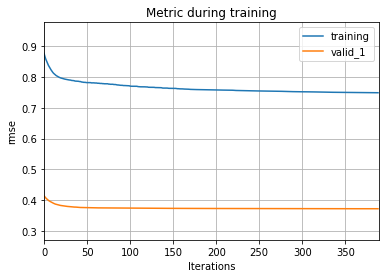

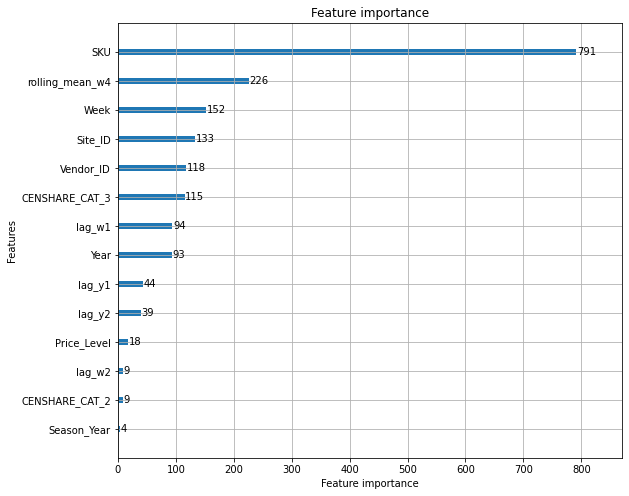

****** 2020W45 ******


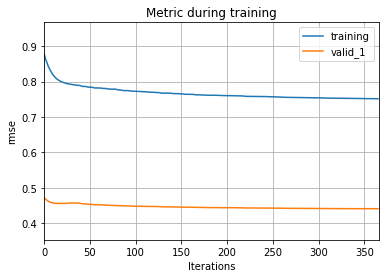

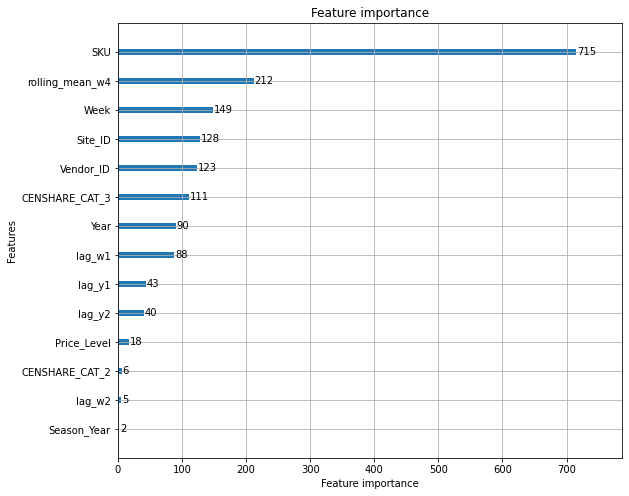

****** 2020W44 ******


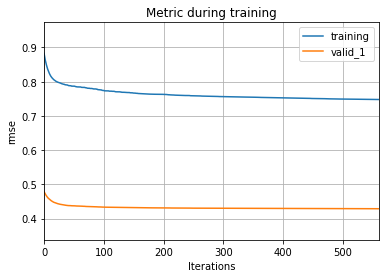

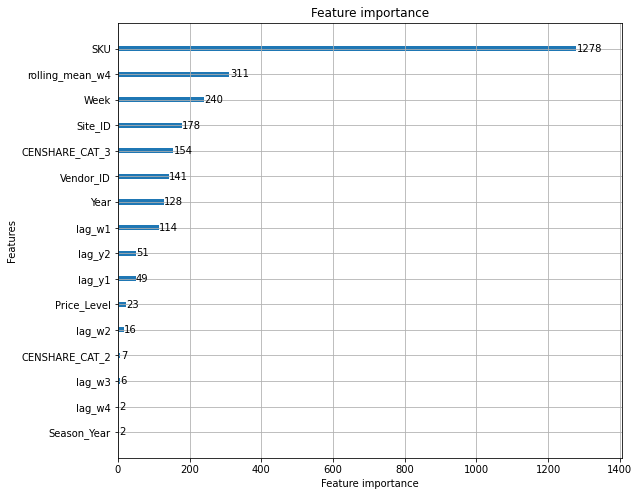

****** 2020W43 ******


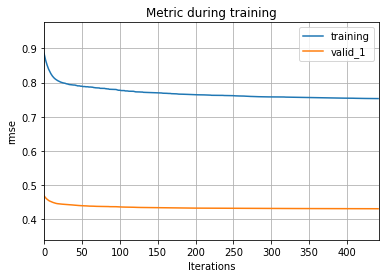

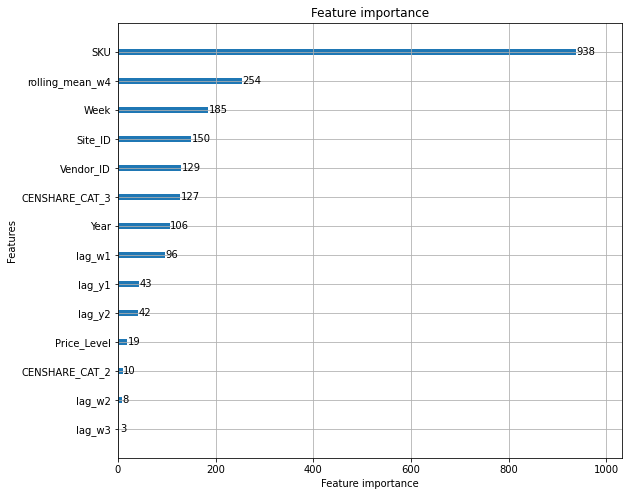

****** 2020W42 ******


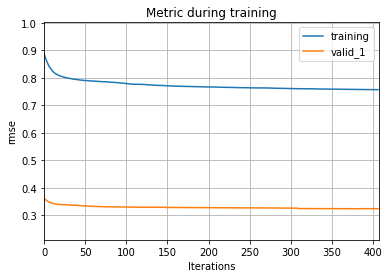

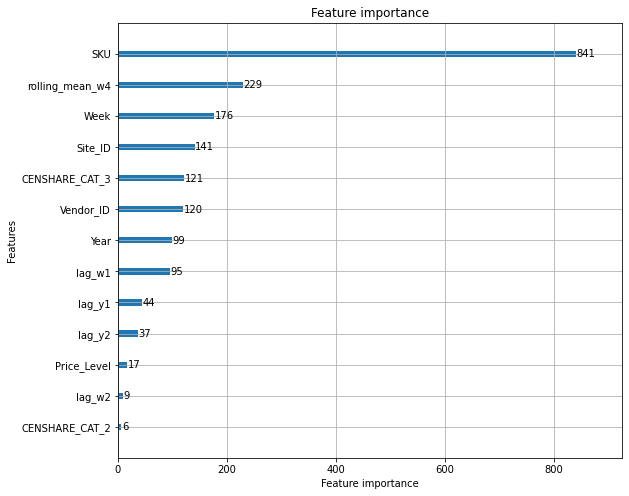

In [15]:
for week, year in splits:
    print(f'****** {year}W{week} ******')
    
    mod = lgb.Booster(model_file=path_models + f'gbm_{year}w{week}.txt')
    evals = pickle.load(open(path_models + f'evals_result_{year}w{week}.pkl', 'rb'))

    ax = lgb.plot_metric(evals)
    plt.show()
    
    ax = lgb.plot_importance(mod, figsize=(10,8))
    plt.gcf().subplots_adjust(left=0.2)
    plt.show()
    

# Compute Min Stock for next Week

In [16]:
for week, year in [splits[0]]:
    week=int(week)
    year=int(year)
    
    # Train data: same year and past week OR past year
    x_train = df.loc[((df.Year == (Week(year, week))[0]) & (df.Week <= (Week(year, week))[1])) | (df.Year < (Week(year, week))[0])][features]
    y_train = df.loc[((df.Year == (Week(year, week))[0]) & (df.Week <= (Week(year, week))[1])) | (df.Year < (Week(year, week))[0])][target_variable]

    x_test = df.loc[df.Year == (Week(year, week)+1)[0]].loc[df.Week == (Week(year, week)+1)[1]][features]
    y_test = df.loc[df.Year == (Week(year, week)+1)[0]].loc[df.Week == (Week(year, week)+1)[1]][target_variable]
    
    
    
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_test, label=y_test, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )
    
    
    
    gbm = lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                   )

    
    y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)

c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4460
[LightGBM] [Info] Number of data points in the train set: 3132349, number of used features: 18
[LightGBM] [Info] Start training from score -1.633538
Training until validation scores don't improve for 20 rounds


c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\dev\verteiler\venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 0.793587	valid_1's rmse: 0.38055
[50]	training's rmse: 0.782291	valid_1's rmse: 0.375741
[75]	training's rmse: 0.778344	valid_1's rmse: 0.374442
[100]	training's rmse: 0.771835	valid_1's rmse: 0.373919
[125]	training's rmse: 0.766917	valid_1's rmse: 0.373503
[150]	training's rmse: 0.763483	valid_1's rmse: 0.373325
[175]	training's rmse: 0.759647	valid_1's rmse: 0.373079
[200]	training's rmse: 0.75828	valid_1's rmse: 0.372853
[225]	training's rmse: 0.756545	valid_1's rmse: 0.372714
[250]	training's rmse: 0.755053	valid_1's rmse: 0.372518
[275]	training's rmse: 0.75419	valid_1's rmse: 0.372434
[300]	training's rmse: 0.75235	valid_1's rmse: 0.372331
[325]	training's rmse: 0.751431	valid_1's rmse: 0.372209
[350]	training's rmse: 0.750407	valid_1's rmse: 0.372118
[375]	training's rmse: 0.749709	valid_1's rmse: 0.372083
Early stopping, best iteration is:
[369]	training's rmse: 0.749832	valid_1's rmse: 0.372075


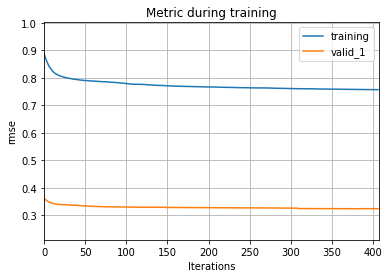

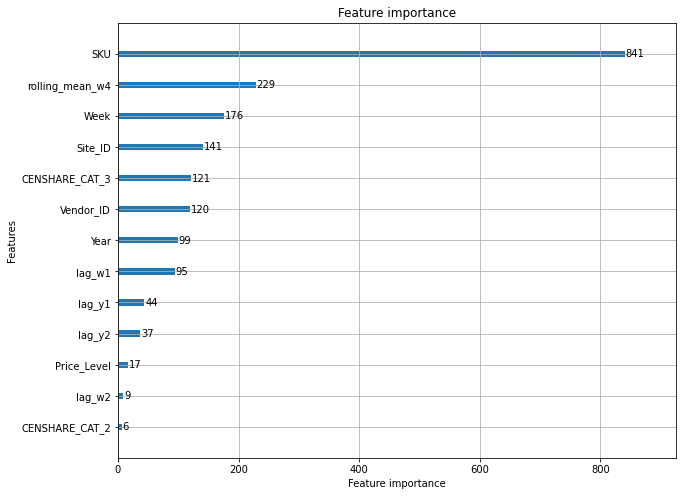

In [17]:
ax = lgb.plot_metric(evals)
plt.show()

ax = lgb.plot_importance(mod, figsize=(10,8))

In [18]:
relevant_columns = ['Week','Year','Site_ID','SKU','Forecast','Min Stock','Target (Sales QTY)','Prediction Error (Sales QTY)','Turnover','Article_Desc','Mainsector_ID','Mainsector_Desc','Warengruppe_ID', 'Warengruppe_Desc','Vendor_ID', 'Vendor_Name']
stock = df_raw.loc[df_raw.Year == (Week(year, week)+1)[0]].loc[df_raw.Week == (Week(year, week)+1)[1]].copy()
stock.loc[:, 'Forecast'] = np.round(y_pred,2)
stock.loc[:, 'Min Stock'] = np.ceil(stock['Forecast'] * 2).clip(lower=1)
stock.loc[:, 'Target (Sales QTY)'] = y_test.to_list()
stock.loc[:, 'Prediction Error (Sales QTY)'] = np.round(abs(y_pred - y_test.to_list()) ,2)
stock = stock.loc[:,relevant_columns]
stock = stock.rename(columns={'SKU': 'Article_ID', 'Turnover': 'Target (Turnover)'})
stock = stock.sort_values(by=['Min Stock', 'Forecast'], ascending=False)
stock.to_csv('Wareverschiebung-VZ-zu-Filiale.csv', index=False, encoding='utf-8')
stock

,Week,Year,Site_ID,Article_ID,Forecast,Min Stock,Target (Sales QTY),Prediction Error (Sales QTY),Target (Turnover),Article_Desc,Mainsector_ID,Mainsector_Desc,Warengruppe_ID,Warengruppe_Desc,Vendor_ID,Vendor_Name
239844,47,2020,107,13741603,4.08,9.0,3.0,1.08,59.700001,SOCKEN 10-024/1BASIS 41/42 09 SCHWARZ,20,Herren-Mode,566,Socken,0000124354,Jacob Rohner AG
940935,47,2020,101,1021984505,2.62,6.0,0.0,2.62,0.000000,"SOCKEN 2ER PACK 371111 C, schwarz, 39-42",20,Herren-Mode,566,Socken,0000945636,stichd bv
943812,47,2020,590,1021984505,2.62,6.0,12.0,9.38,238.800003,"SOCKEN 2ER PACK 371111 C, schwarz, 39-42",20,Herren-Mode,566,Socken,0000945636,stichd bv
238568,47,2020,102,13741603,2.60,6.0,4.0,1.40,79.599998,SOCKEN 10-024/1BASIS 41/42 09 SCHWARZ,20,Herren-Mode,566,Socken,0000124354,Jacob Rohner AG
215866,47,2020,107,13741213,2.55,6.0,0.0,2.55,0.000000,SOCKEN 10-064/1 BASI 43/44 09 SCHWARZ,20,Herren-Mode,566,Socken,0000124354,Jacob Rohner AG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642005,47,2020,106,1261409122,0.01,1.0,0.0,0.01,0.000000,"34.19 ROYR Cast Classic Che, schwarz, 41",20,Herren-Mode,570,Herrenschuhe,0000946076,Royal Republiq
2665051,47,2020,115,1261441214,0.01,1.0,0.0,0.01,0.000000,"Dsq._Boxer CMD 2P DCXF50050, weiss, XL",20,Herren-Mode,567,Wäsche/Bade,0000426650,Isa Seta SPA
2678798,47,2020,106,1261441510,0.01,1.0,0.0,0.01,0.000000,"Dsq._Slip 3P DCX610040 CO/, schwarz, XXL",20,Herren-Mode,567,Wäsche/Bade,0000426650,Isa Seta SPA
2687540,47,2020,106,1261441705,0.01,1.0,0.0,0.01,0.000000,"Dsq._T-Shirt RN 2P DCX200050, schwarz, S",20,Herren-Mode,567,Wäsche/Bade,0000426650,Isa Seta SPA


In [20]:
# Analyse the greatest Errors
stock.sort_values(by=['Prediction Error (Sales QTY)'], ascending=False).head(25)

,Week,Year,Site_ID,Article_ID,Forecast,Min Stock,Target (Sales QTY),Prediction Error (Sales QTY),Target (Turnover),Article_Desc,Mainsector_ID,Mainsector_Desc,Warengruppe_ID,Warengruppe_Desc,Vendor_ID,Vendor_Name
1889110,47,2020,101,1176185807,0.16,1.0,14.0,13.84,901.390015,"BOXER 172-1464 PURE COMFORT, schwarz, L",20,Herren-Mode,567,Wäsche/Bade,0000185793,Zimmerli Textil AG
947141,47,2020,590,1021984506,1.98,4.0,13.0,11.02,258.700012,"SOCKEN 2ER PACK 371111 C, schwarz, 43-46",20,Herren-Mode,566,Socken,0000945636,stichd bv
943812,47,2020,590,1021984505,2.62,6.0,12.0,9.38,238.800003,"SOCKEN 2ER PACK 371111 C, schwarz, 39-42",20,Herren-Mode,566,Socken,0000945636,stichd bv
210164,47,2020,102,13741205,0.71,2.0,10.0,9.29,199.000000,SOCKEN 10-064/1 BASI 41/42 09 SCHWARZ,20,Herren-Mode,566,Socken,0000124354,Jacob Rohner AG
2764190,47,2020,101,1261745607,0.41,1.0,9.0,8.59,621.000000,"Zim_Boxer Business Class 222, schwarz, M",20,Herren-Mode,567,Wäsche/Bade,0000185793,Zimmerli Textil AG
542266,47,2020,590,31158266,0.38,1.0,7.0,6.62,349.299988,PANT UNI M SCHWARZ,20,Herren-Mode,567,Wäsche/Bade,0000194449,Hanro AG
266673,47,2020,102,14292097,0.45,1.0,7.0,6.55,124.580002,SOCKEN 10-064/1 BASI 41/42 213 MARENGO,20,Herren-Mode,566,Socken,0000124354,Jacob Rohner AG
1795612,47,2020,102,1174556805,0.06,1.0,6.0,5.94,479.220001,"T-SHIRT RN 700-1341 Pureness, weiss, XXL",20,Herren-Mode,567,Wäsche/Bade,0000185793,Zimmerli Textil AG
2905059,47,2020,115,1272472622,0.07,1.0,6.0,5.93,359.399994,"NOS_FIBRETEX_MERINO_CARDIGAN, schwarz, M",20,Herren-Mode,573,Eigenmarke Casual,0000948722,Fibretex SPA
2764849,47,2020,590,1261745607,0.09,1.0,6.0,5.91,414.000000,"Zim_Boxer Business Class 222, schwarz, M",20,Herren-Mode,567,Wäsche/Bade,0000185793,Zimmerli Textil AG
